In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import InMemorySaver

import requests
import os
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, ToolCall
from pydantic import BaseModel
from graphs.COMPONENTS import MCP_LLM_NODE_GENERATOR, MCP_TOOL_NODE_GENERATOR, MCP_EDGE_GENERATOR, get_tools


In [19]:
from langchain_ollama import ChatOllama
import os

ollama_url = os.getenv('OLLAMA_URL')

llm = ChatOllama(model='qwen3:14b', base_url=ollama_url)

In [11]:
from pymongo import MongoClient

In [12]:
mongo_uri = os.getenv('ME_CONFIG_MONGODB_URL')
client = MongoClient(mongo_uri)

In [14]:
db = client['test_db']

In [15]:
col = db['test_col']

In [17]:
col.insert_one({'Hi': 'World'})

InsertOneResult(ObjectId('68620aeb22563a98fe326758'), acknowledged=True)

## FETCH SERVER

In [21]:
server = 'fetch'

tools = get_tools(server)

In [22]:
fetch_template = """
You are a specialized web‐content extraction agent.

Fetch the page: `{page_url}`, call the tool with a max_length of 2000 characters
"""

In [23]:
fetch_prompt = fetch_template.format(page_url = 'www.bbva.mx/personas/productos/creditos/credito-hipotecario/cuenta-infonavit-credito-bancario.html')

In [14]:
FETCH_LLM_NODE = MCP_LLM_NODE_GENERATOR(server)

In [15]:
FETCH_TOOL_NODE = MCP_TOOL_NODE_GENERATOR(server)

In [16]:
FETCH_EDGE = MCP_EDGE_GENERATOR(server)

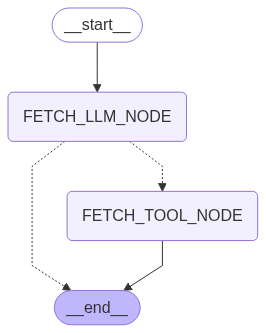

In [17]:
from IPython.display import Image, display

fetch_builder = StateGraph(MessagesState)

fetch_builder.add_node('FETCH_LLM_NODE', FETCH_LLM_NODE)
fetch_builder.add_node('FETCH_TOOL_NODE', FETCH_TOOL_NODE)

fetch_builder.add_edge(START, 'FETCH_LLM_NODE')
fetch_builder.add_conditional_edges('FETCH_LLM_NODE', FETCH_EDGE)

fetch_checkpointer = InMemorySaver()

fecth_graph = fetch_builder.compile(checkpointer=fetch_checkpointer)

display(Image(fecth_graph.get_graph().draw_mermaid_png()))

In [24]:
fetch_config = {"configurable": {"thread_id": "1", 'llm': llm}}

In [25]:
fetch_checkpointer.delete_thread("1")

In [27]:
for state in fecth_graph.stream({'messages':fetch_prompt},config=fetch_config, stream_mode="updates"):
    print(state)

{'FETCH_LLM_NODE': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:14b', 'created_at': '2025-06-29T16:17:36.099751067Z', 'done': True, 'done_reason': 'stop', 'total_duration': 59367003064, 'load_duration': 52968177151, 'prompt_eval_count': 242, 'prompt_eval_duration': 539438027, 'eval_count': 325, 'eval_duration': 5858069252, 'model_name': 'qwen3:14b'}, id='run--cbb89ab8-2b5f-4a33-bb80-626b0021932e-0', tool_calls=[{'name': 'fetch', 'args': {'max_length': 2000, 'url': 'www.bbva.mx/personas/productos/creditos/credito-hipotecario/cuenta-infonavit-credito-bancario.html'}, 'id': 'bf7ce4e8-fd44-4da9-89b0-2b012a2f50c4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 242, 'output_tokens': 325, 'total_tokens': 567})}}
{'FETCH_TOOL_NODE': {'messages': [ToolMessage(content="1 validation error for Fetch\nurl\n  Input should be a valid URL, relative URL without a base [type=url_parsing, input_value='www.bbva.mx/personas/pro...t-credito-bancario.ht

In [28]:
from IPython.display import Markdown, display

ss2 = fecth_graph.get_state(fetch_config)

display(Markdown(ss2.values['messages'][-1].content))

1 validation error for Fetch
url
  Input should be a valid URL, relative URL without a base [type=url_parsing, input_value='www.bbva.mx/personas/pro...t-credito-bancario.html', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/url_parsing

In [40]:
SYSTEM_INSTRUCTIONS = """You are an expert assistant in technical documentation and structured writing. You will receive an input text in Markdown format that lacks clear structure—it may include poorly defined headers, disorganized paragraphs, unformatted lists, and inconsistent hierarchy.

Your task is to rewrite this Markdown by applying the following rules:

1. Identify and correct headers, assigning appropriate levels (`#`, `##`, etc.) based on content hierarchy.
2. Organize text into logical sections with descriptive titles.
3. Convert textual elements that resemble lists or steps into proper bullet points (`-`, `*`) or numbered lists.
4. Apply consistent formatting to code snippets, links, and annotations.
5. Do not remove any information, but you may reorganize it for better clarity and flow.
6. Do not invent content—only restructure what’s already provided.
7. The output should be a clean, professional Markdown file ready for presentation or publication.
"""

In [43]:
system = SystemMessage(content=SYSTEM_INSTRUCTIONS)

In [33]:
text = """![BBVA México | Tarjetas, Créditos, Hipotecas, Cuentas, Seguros, Nóminas, Portabilidad](/content/dam/library/logos/logo-bbva.svg)\n![](/content/dam/library/icons/leaf.svg)\n![](/content/dam/library/icons/5_006_wellness.svg)\n![](/content/dam/library/icons/2_042_nearme.svg)\n![](/content/dam/library/icons/3_026_mobile.svg)\n![](/content/dam/library/icons/2_027_place.svg)\n![](/content/dam/library/icons/4_003_help.svg)\n![](/content/dam/library/icons/1_028_international.svg)\n![](/content/dam/library/icons/5_007_education.svg)\n\nOportunidades\n\n![Comienza con BBVA](/content/dam/library/micros/products-bancomer-opportunity-menu-glass.im1746789950017im.png?imwidth=1176)\n\nComienza con BBVA\n\nDisfruta los beneficios que tenemos para ti\n\n![Vive tranquilo en tu hogar](/content/dam/library/micros/home-loan-opportunity-menu-glass.im1746467373358im.png?imwidth=1176)\n\nVive tranquilo en tu hogar\n\nElige tu casa y protégela\n\n![Un vehículo para tu estilo de vida](/content/dam/library/micros/car-opportunity-menu-glass.im1746463651672im.png?imwidth=1176)\n\nUn vehículo para tu estilo de vida\n\nElige tu vehículo o moto y disfruta de la mejor protección.\n\n![Dinero para cualquier imprevisto](/content/dam/library/micros/money-loan-fast-opportunity-menu-glass.im1746467373982im.png?imwidth=1176)\n\nDinero para cualquier imprevisto\n\nApoyo inmediato en el momento indicado\n\n![Invierte y planifica tu futuro](/content/dam/library/micros/future-investment-opportunity-menu-glass.im1746467373002im.png?imwidth=1176)\n\nInvierte y planifica tu futuro\n\nConoce cómo ahorrar o invertir tu dinero.\n\n![Desarrolla tu negocio](/content/dam/library/micros/bussiness-opportunity-menu-glass.im0im.png?imwidth=80)\n\nDesarrolla tu negocio\n\nComienza o impulsa tu empresa.\n\n![Contrata en minutos tu tarjeta de crédito BBVA](/content/dam/public-web/mexico/images/tc-azul-conf-2.im1747937438745im.png?imwidth=1176)\n\n¡Contrata en 5 min tu tarjeta de crédito!\n\n![](/content/dam/library/icons/leaf.svg)\n![](/content/dam/library/icons/5_006_wellness.svg)\n![](/content/dam/library/icons/2_042_nearme.svg)\n![](/content/dam/library/icons/3_026_mobile.svg)\n![](/content/dam/library/icons/2_027_place.svg)\n![](/content/dam/library/icons/4_003_help.svg)\n![](/content/dam/library/icons/1_028_international.svg)\n![](/content/dam/library/icons/5_007_education.svg)\n![](/content/dam/library/logos/logo_bbva_print.svg)\n![](/content/dam/public-web/mexico/photos/familia-en-casa-viendo-laptop-marquee.im1747932714982im.jpg?imwidth=3200)\n\n# Cuenta Infonavit + Crédito Bancario\n\n## Compra una vivienda nueva o usada\n\nTasa desde\n\n**9.50%**\n\nhasta **11.70%**\n\n**14.9%**\n\nConoce las ventajas de este crédito\n\n![](/content/dam/library/icons/1_027_mortaje.svg)\n![](/content/dam/library/icons/2_024_correct.svg)\n![](/content/dam/library/icons/1_002_dollar.svg)\n![](/content/dam/library/icons/3_004_calendar.svg)\n![](/content/dam/library/icons/1_023_loan.svg)\n![](/content/dam/library/icons/1_051_taxes.svg)\n![](/content/dam/library/icons/1_031_contract.svg)\n\n### ¿Qué te ofrece este crédito?\n\n### Sin penalización\n\n### Tasa desde 9.40% hasta 11.70%\n\n![](/content/dam/library/icons/1_024_insurance.svg)\n\n### Paquete integral de seguros\n\nAl contratar tu crédito, te ofrecemos estos seguros para proteger lo que ya es tuyo.\n\nLa contratación de los seguros es opcional con Seguros BBVA.\n\n### $0.600\n\n#### Por cada $1,000 de suma asegurada\n\n### $0.1593\n\n#### Por cada $1,000 de suma asegurada + $30.76 + IVA\n\nAdemás, cuentas con:\n\n- Seguros de Contenidos del Hogar\n\n- Seguro de Responsabilidad Civil\n\n![](/content/dam/library/icons/3_021_document.svg)\n\n### ¿Qué necesitas para tramitar?\n\nConsulta [aquí](#documentacion) los requisitos que debe cumplir tu vivienda para servir como garantía del crédito que solicitas.\n\nPresenta los documentos anteriores en la sucursal más cercana.\n\nConsulta [aquí](#documentacion) la lista completa de documentos que requerirás a lo largo del proceso de contratación. \n\n![](/content/dam/library/icons/1_002_dollar.svg)\n\n### ¿Cuáles son los costos?\n\n### CAT promedio de 14.9% sin IVA\n\n### 0.50%\n\n#### Comisión por Contratación - crédito\\*\n\nComisión por contratación - crédito: Esta comisión es pagadera en moneda nacional y exigible por única ocasión a la fecha de formalización del crédito hipotecario, su cobro es calculado sobre el monto financiado y se genera por la formalización y trámites administrativos de la apertura del crédito.\n\nLas comisiones están exentas del pago de impuesto al valor agregado (IVA).\n\n\\*Por única vez de la contratación.\n\n### 0.025%\n\n#### Sobre el monto financiado\n\n### Avalúo Bancario\n\n### Requisitos del solicitante\n\n**Si cumples con lo siguiente, eres candidato para recibir un crédito:**\n\n### Requisitos de la vivienda\n\n**Tu vivienda debe cumplir con estas características para poder servir como garantía de tu crédito:**\n\n### Documentación\n\n**1. Para iniciar tu trámite:**\n\n**2. Para valuar tu inmueble:**\n\n**3. Para formalizar tu trámite:**\n\n### Base de cobro de Gastos de Preoriginación - avalúo hipotecario\n\nBase de cobro Gastos de Preoriginación - avalúo hipotecario: Por única ocasión, en razón del valor de la vivienda que el cliente manifieste en su solicitud de crédito, exigible al momento de solicitar los servicios de valuación inmobiliaria.\n\nComisión por Gastos de Preoriginación - avalúo hipotecario; costos de medición: $1,134 (no incluye IVA) cuando la vivienda no cuenta con planos arquitectónicos del inmueble, se cobrará adicional los Gastos de Preoriginación - avalúo hipotecario; costos de medición, por única ocasión.\n\nA continuación la tabla detallada de tarifas de avalúo:\n\n| **Rango de valor** | **Costo total del servicio (incluye IVA)** | **+  Gastos de Preoriginación - avalúo hipotecario; costos de medición (no incluye IVA)** |\n| --- | --- | --- |\n| $0 a   $500,000 | $2,500 | $1,134 |\n| $500,000.01 a  $1,000,000 | $3,700 | $1,134 |\n| $1,000,000.01   a $1,500,000 | $5,000 | $1,134 |\n| $1,500,000.01   a $2,000,000 | $6,600 | $1,134 |\n| $2,000,000.01   a $3,000,000 | $8,500 | $1,134 |\n| $3,000,000.01   a $4,000,000 | $11,200 | $1,134 |\n| $4,000,000.01   a $6,000,000 | $14,500 | $1,134 |\n| $6,000,000.01   a $10,000,000 | $20,000 | $1,134 |\n| $10,000,000.01   a $15,000,000 | $30,000 | $1,134 |\n| De $15,000,000.01   en adelante | $45,000 | $1,134 |\n\n**Costo total del servicio (incluye IVA)**\n\n**+  Gastos de Preoriginación - avalúo hipotecario; costos de medición (no incluye IVA)**\n\n$0 a   \n $500,000\n\n$2,500\n\n$500,000.01 a  \n $1,000,000\n\n$3,700\n\n$1,000,000.01  \n  a $1,500,000\n\n$5,000\n\n$1,500,000.01  \n  a $2,000,000\n\n$6,600\n\n$2,000,000.01  \n  a $3,000,000\n\n$8,500\n\n$3,000,000.01  \n  a $4,000,000\n\n$11,200\n\n$4,000,000.01  \n  a $6,000,000\n\n$14,500\n\n$6,000,000.01  \n  a $10,000,000\n\n$20,000\n\n$10,000,000.01  \n  a $15,000,000\n\n$30,000\n\nDe $15,000,000.01  \n  en adelante\n\n$45,000\n\n### Advertencia\n\n### Preguntas Frecuentes\n\n## ¿Tienes dudas?\n\n### Preguntas Frecuentes\n\n## ¿A partir de que día puedo pagar la mensualidad de mi crédito hipotecario?\n\n## ¿Cuál es la fecha límite de pago?\n\n## ¿Qué pasa si no pago mi mensualidad completa y a tiempo (último día hábil del mes)?\n\nNo estar al corriente con tus pagos te traerá algunas desventajas que afectarán tu economía, historial crediticio y la seguridad de tu patrimonio:\n\n## ¿Cómo puedo realizar el pago de mi crédito TOM?\n\nPara mayor información comunícate al 55-1102-0015 desde Ciudad de México.\n\n## ¿Cómo realizo el trámite para que carguen la mensualidad del crédito hipotecario a mi cuenta?\n\nEn qué consiste:\n\nEs la domiciliación de una cuenta para el cobro de la mensualidad de forma automática. El cobro automático se realiza el día último hábil de cada mes, no se pueden domiciliar tarjetas de crédito o cuentas de inversión a plazo. También es posible domiciliar cuentas de otras Instituciones Financieras.\n\nRequisitos:\n\nAutorización del titular de la cuenta que debe contener el número de la cuenta a domiciliar, una identificación oficial con fotografía y firma del titular. El cliente deberá tener saldo suficiente en el día que se efectúa el cargo (último día hábil del mes). Las comisiones de la cuenta se aplican con base a los términos estipulados en el contrato de la cuenta.\n\n## ¿Dónde se tramita?\n\n## ¿Cómo pago mi crédito si resido en el extranjero?\n\nSi resides en el extranjero, estas son las opciones de pago para tu crédito \"Tu Opción en México\":\n\nVincula el pago de tu mensualidad a tu cuenta BBVA\\*, llamando al [011-52-55-1102 0015](tel:011525511020015) agregando (011-52-55) desde Estados Unidos (es necesario que tengas una cuenta activa con BBVA).\n\nMoney Order Consulta como llenarlo.\n\nCheque Consulta como llenarlo.\n\n\\*La cuenta deberá estar a nombre del titular del crédito.\n\nNota: Para los pagos con Money Order o Cheque, deberás tomar en cuenta el tiempo de envío, por lo que te sugerimos realizar tu pago del día 15 al 20 de cada mes, así, evitarás contratiempos.\n\n## ¿Cómo tramito mi Adhesión al Programa de Apoyo Infonavit?\n\nEn que consiste:\n\nSi ya tienes tu crédito Hipotecario lo puedes inscribir al programa de apoyo INFONAVIT, en el cual las aportaciones del 5% que realiza tu patrón se aplican al pago de tu crédito (pagos a capital), teniendo grandes beneficios.\n\nBeneficios\n\nDisminución del plazo o mensualidades vencidas del crédito según escritura.\n\nAhorro en el cobro de intereses.\n\nEn caso de perder tu empleo el saldo acumulado en la subcuenta de vivienda se aplica a las mensualidades del crédito y se interrumpe cuando recuperes tu relación laboral, aunque sigas teniendo saldo en la subcuenta.\n\nRequisitos\n\nHaber Formalizado el crédito a partir del 2002 (no aplica años anteriores).\n\nSer derechohabiente del Infonavit con relación laboral vigente.\n\nNo tener un crédito vigente del Infonavit.\n\nFirmar convenio modificatorio ante Notario Público.\n\nFirmar Carta de Instrucción Irrevocable 43BIS.\n\nQue el crédito otorgado por el Banco haya sido destinado para comprar una casa nueva o usada.\n\nDocumentos Requeridos.\n\n Copia del último testimonio Firmado.\n\nCopia de Identificación Oficial.\n\nCopia Predial al corriente.\n\n## Documentos de interés\n\n### \n\n### \n\n### \n\n### ¿Quieres hacernos algún comentario?\n\n### Unidad Especializada en Atención a Clientes (UNE)\n\nTe invitamos a contactarnos.\n\nPara consultas, reclamaciones y aclaraciones:\n\nEstamos a tus órdenes en nuestras oficinas en Lago Alberto 320 (entrada por Mariano Escobedo 303), colonia Granada, código postal 11320, alcaldía Miguel Hidalgo, Ciudad de México; Business Center planta baja. Entre Laguna de Mayrán y Lago Alberto, de lunes a viernes de 09:00 a 14:00 horas.\n\nTambién puedes llamarnos al [55 1998 8039](tel:5519988039 \"Abre en nueva ventana\") de lunes a viernes de 08:30 a 17:30 horas, desde cualquier parte de la República Mexicana.\n\nO envíanos por correo electrónico a [une.mx@bbva.com](mailto:une.mx@bbva.com \"Abre en nueva ventana\"), una carta firmada donde nos cuentes lo que sucedió; si tienes evidencia de lo sucedido inclúyela en el correo, además de una imagen, en formato .JPG o .PDF, de tu identificación oficial (INE, pasaporte, cédula profesional menor a diez años de antigüedad).\n\n### Condusef\n\nLa Comisión Nacional para la Protección y Defensa de los Usuarios de los Servicios Financieros (Condusef) está a tu disposición en su domicilio:\n\nInsurgentes Sur 762, Colonia del Valle, alcaldía Benito Juárez, código postal 03100, Ciudad de México.\n\nComunícate a los teléfonos:\n\nSi lo prefieres, escribe un correo electrónico a:\n\n[asesoria@condusef.gob.mx](mailto:asesoria@condusef.gob.mx \"Open in a new browser\"),\n\no visita el sitio\n\nAtención al cliente\n\nContáctanos\n\nCAT promedio 14.9% sin IVA\n\nEl cálculo del CAT para este producto se efectuó considerando los valores de vivienda promedios establecidos por la Sociedad Hipotecaria Federal, S.N.C., I.B.D., (económica $732,901.73 pesos, moneda nacional; media $1’738,012.61 pesos, moneda nacional; residencial $3’811,053.80 pesos, moneda nacional y residencial plus $7’999,015.80 pesos, moneda nacional), con un aforo al 80% y un plazo a 15 años.\n\nPara fines informativos y de comparación. \n\nFecha de cálculo: 03 de febrero de 2025. Vigencia de la oferta hasta el 31 de agosto de 2025.\n\nPara conocer el CAT específico del producto, así como los términos y requisitos de contratación, condiciones financieras, monto y conceptos de las comisiones aplicables llama al Centro de Atención Hipotecario a través del [55 1102 0015](tel:55%201102%200015) o bien acude a una sucursal.\n\nCentro de Ayuda\n\nInformación Corporativa\n\nOtros sitios BBVA\n\nEn BBVA vivimos la igualdad de oportunidades\n\nNos ponemos en el lugar de los demás siendo conscientes de nuestras diferencias; por ello, promovemos nuestros valores y contamos con lineamientos que promueven la igualdad, el respeto y la no discriminación para que todas las personas reciban un trato digno y equitativo.\n\n[**Trabajando por un sitio accesible para todos.**](/content/dam/public-web/mexico/documents/Accesibilidad_Ilunion.pdf \"Open in a new browser\")\n\n![BBVA México | Tarjetas, Créditos, Hipotecas, Cuentas, Seguros, Nóminas, Portabilidad](/content/dam/library/logos/logo-bbva.svg)\n\n© 2025 BBVA México, S.A., Institución de Banca Múltiple, Grupo Financiero BBVA México. Avenida Paseo de la Reforma 510, colonia Juárez, código postal 06600, alcaldía Cuauhtémoc, Ciudad de México."""

In [44]:
input_text = HumanMessage(F"Structure the text:\n\n{text}")

In [45]:
system+input_text

ChatPromptTemplate(input_variables=[], input_types={}, partial_variables={}, messages=[SystemMessage(content='You are an expert assistant in technical documentation and structured writing. You will receive an input text in Markdown format that lacks clear structure—it may include poorly defined headers, disorganized paragraphs, unformatted lists, and inconsistent hierarchy.\n\nYour task is to rewrite this Markdown by applying the following rules:\n\n1. Identify and correct headers, assigning appropriate levels (`#`, `##`, etc.) based on content hierarchy.\n2. Organize text into logical sections with descriptive titles.\n3. Convert textual elements that resemble lists or steps into proper bullet points (`-`, `*`) or numbered lists.\n4. Apply consistent formatting to code snippets, links, and annotations.\n5. Do not remove any information, but you may reorganize it for better clarity and flow.\n6. Do not invent content—only restructure what’s already provided.\n7. The output should be a 

In [48]:
strctured = llm.invoke([system,input_text])

In [60]:
strctured.content.split("</think>\n\n")[-1]

'### **Resumen del Programa de Crédito Hipotecario BBVA México**\n\n---\n\n#### **1. Información General del Crédito**\n- **CAT (Costo Anual Total):**  \n  - **Promedio:** 14.9% sin IVA.  \n  - **Cálculo:** Basado en promedios de vivienda establecidos por la Sociedad Hipotecaria Federal (valores de $732,901.73 a $7,999,015.80).  \n  - **Vigencia:** Hasta el 31 de agosto de 2025.  \n\n- **Plazo y Aforo:**  \n  - Plazo máximo: 15 años.  \n  - Aforo máximo: 80% del valor de la vivienda.  \n\n---\n\n#### **2. Opciones de Pago**\n- **Pago en México:**  \n  - **Domiciliación automática:** Cobro el último día hábil del mes en una cuenta BBVA (no se aceptan tarjetas de crédito o cuentas de inversión).  \n  - **Canal de pago:** Llamada a **55-1102-0015** desde CDMX.  \n\n- **Pago desde el extranjero (Programa "Tu Opción en México"):**  \n  - **Opciones:**  \n    - Vincular pago a cuenta BBVA (llamar a **011-52-55-1102-0015**).  \n    - **Money Order** o **Cheque** (con recomendación de pagar en

In [61]:
from IPython.display import Markdown, display

display(Markdown(strctured.content.split("</think>\n\n")[-1]))

### **Resumen del Programa de Crédito Hipotecario BBVA México**

---

#### **1. Información General del Crédito**
- **CAT (Costo Anual Total):**  
  - **Promedio:** 14.9% sin IVA.  
  - **Cálculo:** Basado en promedios de vivienda establecidos por la Sociedad Hipotecaria Federal (valores de $732,901.73 a $7,999,015.80).  
  - **Vigencia:** Hasta el 31 de agosto de 2025.  

- **Plazo y Aforo:**  
  - Plazo máximo: 15 años.  
  - Aforo máximo: 80% del valor de la vivienda.  

---

#### **2. Opciones de Pago**
- **Pago en México:**  
  - **Domiciliación automática:** Cobro el último día hábil del mes en una cuenta BBVA (no se aceptan tarjetas de crédito o cuentas de inversión).  
  - **Canal de pago:** Llamada a **55-1102-0015** desde CDMX.  

- **Pago desde el extranjero (Programa "Tu Opción en México"):**  
  - **Opciones:**  
    - Vincular pago a cuenta BBVA (llamar a **011-52-55-1102-0015**).  
    - **Money Order** o **Cheque** (con recomendación de pagar entre el día 15 y 20 del mes).  

---

#### **3. Preguntas Frecuentes**
- **¿Qué pasa si no pago a tiempo?**  
  - Consecuencias: Afecta el historial crediticio, incrementa intereses, y puede llevar a la pérdida del patrimonio.  

- **¿Cómo adherir al Programa de Apoyo Infonavit?**  
  - **Requisitos:**  
    - Crédito hipotecario formalizado a partir de 2002.  
    - Ser derechohabiente Infonavit con relación laboral vigente.  
    - No tener otro crédito Infonavit.  
  - **Beneficios:**  
    - Aplicación de aportaciones del 5% del patrón al pago del capital.  
    - Reducción de plazo o mensualidades.  

---

#### **4. Contacto y Atención al Cliente**
- **Unidad Especializada en Atención a Clientes (UNE):**  
  - **Dirección:** Lago Alberto 320, colonia Granada, CDMX.  
  - **Teléfono:** **55 1998 8039** (lunes a viernes, 08:30-17:30).  
  - **Correo:** **une.mx@bbva.com** (adjuntar identificación oficial y evidencia).  

- **Condusef:**  
  - **Dirección:** Insurgentes Sur 762, CDMX.  
  - **Correo:** **asesoria@condusef.gob.mx**.  

---

#### **5. Advertencias y Legal**
- **Consecuencias de mora:**  
  - Multas, incremento de intereses, y posibilidad de ejecución hipotecaria.  

- **Documentos Requeridos para Adhesión al Infonavit:**  
  - Copia del último testimonio firmado.  
  - Identificación oficial.  
  - Copia del predial al corriente.  

---

#### **6. Políticas Corporativas**
- **Igualdad de oportunidades:** BBVA promueve un trato equitativo y sin discriminación.  
- **Accesibilidad:** Disponibilidad de información en formatos accesibles (ver [enlace](/content/dam/public-web/mexico/documents/Accesibilidad_Ilunion.pdf)).  

---

#### **7. Información Corporativa**
- **Propiedad:** BBVA México, S.A., Grupo Financiero BBVA México.  
- **Dirección:** Avenida Paseo de la Reforma 510, colonia Juárez, CDMX.  

---

**Nota:** Para obtener el CAT específico, términos de contratación o asesoría personalizada, contactar al **Centro de Atención Hipotecario** al **55 1102 0015** o acudir a una sucursal.

In [63]:
len(strctured.content.split("</think>\n\n")[-1])

3012

## DEVELOP OF FOR GRAPH

In [ ]:
from langgraph.graph import START, END, StateGraph

#FOR DATA STRUCTURES
from typing import TypedDict, Literal, Optional

#FOR PARSING XML
from bs4 import BeautifulSoup

from IPython.display import Image, display

In [86]:
class Input_Crawler_State(BaseModel):

    basesite: str
    mapsite: Optional[str] = None


class Crawler_State(Input_Crawler_State):

    links: list[str]
    

In [ ]:
#test_state = Input_Crawler_State(basesite='https://www.bbva.mx/')
test_state = Input_Crawler_State(basesite='https://www.cpm.coop/')

In [ ]:
def GET_LINKS_NODE(state: Input_Crawler_State) -> Crawler_State:
    """Get all the links from a sitemap"""

    #Set Mapsite or valdiate that is an XML
    mapsite = state.mapsite
    if mapsite is None:
        mapsite = state.basesite + 'sitemap.xml'
    elif not mapsite.lower().endswith('.xml'):
        raise ValueError(f"Invalid sitemap: does not end with '.xml'")

    # Fetch sitemap content
    res = requests.get(mapsite, timeout=5.0)
    res.raise_for_status()

    #Parsing the XMLS
    soup =  BeautifulSoup(res.text, 'xml')

    #Filter all the links
    links = []
    for url in soup.find_all('url'):
        
        #Get the full link and the route
        link = url.find('loc').text
        route = link.split(state.basesite)[-1]

        #In case the link doesn't have ending
        if len(route.split('.')) == 1:
            links.append(link)

        #Get only the htmls
        if route.endswith('.html'):
            links.append(link)
     
    #Remove duplcates
    links = list(set(links))

    

In [ ]:
def FILTER_LINKS_NODE(state: Crawler_State):
    """Filter links from html already present on the database"""

    links = state.links

    ####### TO ADD FILTER FROM DATABASE

    return {"links": links[:5]} 

In [270]:
crawler_builder = StateGraph(Crawler_State, input = Input_Crawler_State)

crawler_builder.add_node('GET_LINKS_NODE',GET_LINKS_NODE)
crawler_builder.add_node('FILTER_LINKS_NODE',FILTER_LINKS_NODE)

crawler_builder.add_edge(START, 'GET_LINKS_NODE')
crawler_builder.add_edge('GET_LINKS_NODE', 'FILTER_LINKS_NODE')
crawler_builder.add_edge('FILTER_LINKS_NODE', END)

crawler_graph = crawler_builder.compile()

In [272]:
for chunk in crawler_graph.stream({'basesite': 'https://www.cpm.coop/'}):
    print(chunk)

{'GET_LINKS_NODE': {'links': ['https://www.cpm.coop/credito-inmediato-cpm', 'https://www.cpm.coop/aviso-de-privacidad-credito-y-cobranza', 'https://www.cpm.coop/como-ser-socio-cumplidor', 'https://www.cpm.coop/credito-automotriz-cpm', 'https://www.cpm.coop/', 'https://www.cpm.coop/despacho-de-cobranza', 'https://www.cpm.coop/credito-personal-plus-cpm', 'https://www.cpm.coop/consulta-los-costos-y-comisiones-de-nuestros-productos', 'https://www.cpm.coop/preguntas-frecuentes-sei', 'https://www.cpm.coop/enlacecooperativo', 'https://www.cpm.coop/tarjeta-de-debito', 'https://www.cpm.coop/rendicuenta', 'https://www.cpm.coop/necesitas-un-seguro', 'https://www.cpm.coop/cpm-movil', 'https://www.cpm.coop/ubica-tu-sucursal', 'https://www.cpm.coop/credito-credinamico-cpm', 'https://www.cpm.coop/facecoop', 'https://www.cpm.coop/inmuebles/', 'https://www.cpm.coop/corresponsalias', 'https://www.cpm.coop/consejo-de-seguridad-sei', 'https://www.cpm.coop/credito-productivo-cpm', 'https://www.cpm.coop/qui